# About this Notebook
Hey all,
my goal is to write a **compact guide** on feature engineering.


<div class="alert alert-danger" role="alert">
    <h3>Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>


<a id='top'></a>

<h1 style="background-color:DodgerBlue; color:white" >-> Topics:</h1>

## 1. [Motivation and General Advices](#sec1)
#### 1.1. [Feature-Target Relations and Monotony](#sec11)
#### 1.2. [Pearson Correlation and Collinearity](#sec12)

## 2. [Univariate Transformations on Numerical Data](#sec2)
#### 2.1. [Scaling, Centering, and Standardization](#sec21)
* [Centering and Standardization](#sec211)
* [Range Scaling](#sec212)
* [Robust Scaling](#sec213)

#### 2.2. [Log Transformation](#sec22)
#### 2.3. [Box-Cox Power Transformation](#sec23)
#### 2.4. [Binning with Decision Trees](#sec24) 

## 3. [Encode Categorical Data](#sec3)
#### 3.1. [Label Encoding](#sec31)
#### 3.2. [One-Hot Encoding](#sec32)
#### 3.3. [Target-Mean Encoding](#sec33)


## 4. [Combine interacting Features](#sec-2)
#### 4.1. [Combine Features using Equations](#sec-21)
#### 4.2. [Combine Features using Groupby](#sec-22)
#### 4.3. [Combine Features using Conditions](#sec-23)

## 5. [Distributions](#sec-5)
#### 5.1. [Distribution Tails](#sec51)
#### 5.2. [The Quantile-Quantile Plot (qqplot)](#sec52)

## 6. [Further Readings & Helpful Videos](#sec6)

loading data sets

In [1]:
import pandas as pd 

df_heart = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
trestbps = df_heart['trestbps']
chol = df_heart['chol']
target_heart = df_heart['target']

df_health = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
age = df_health['Age']
target_health = df_health['Response']

<a id="sec1"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 1. Motivation and General Advices</h1>

feature engineering refers to transforming input representations, so that the key relationships between the input and the target can be learned easier by a machine learning model.
key relationships may be between the target and...
* a transformation of *one* feature / different representation of a feature
* a functional relationship between *multiple* features e.g. product or ratio

In best case we engineer relationships between features and the target as...
* **binary flags**
* **monotonic functions**, linear if possible

feature engineering is part of the machine learning loop:
1. collect data
2. get insights into the data 
    - exploratory data analysis
    - domain knowledge
3. deduct design decisions from data insights and implement them
    - data cleaning
    - **feature engineering**
    - train-val-test splitting
    - machine learning model design
4. fit the model
    - training
    - hyperparameter optimization
5. evaluate the model
    - evaluation scores (accuracy, f1, mse, ...)
    - gradcam...
6. deduct design decisions from model evaluation
    - feature selection
    - machine learning model design
7. optionally gather more data, and repeat 1. - 6.


<a id="sec11"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 1.1. Feature-Target Relations and Monotony</h1>

It is best practice to create features which have a **monotonic relationship** with the target because...

* the relationship is easy to interpret for a human
* the machine learning models might converge faster
* the machine learning models often provide better predictions

But what exactly are these monotonic relationships? Let me give you an example:
Imagine having data about some employees of your department, and you want to find out the relationship between their employment *years* and their *salary*. You want to predict your salary over the next years (target=*salary*).

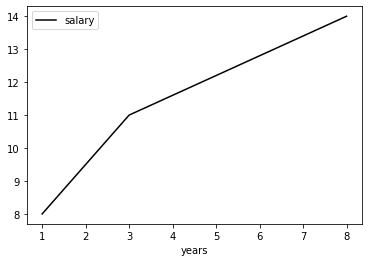

In [2]:
import matplotlib.pyplot as plt

years = [1, 3, 8]
salary = [8, 11, 14]
values = list(zip(years, salary))
names = ['years', 'salary']
df = pd.DataFrame(values, columns=names)
df.plot.line('years', 'salary', color='black')
plt.show()

**strictly monotonic (increasing)** relationship, because the bigger the value of *years*, the bigger the value of *salary*.

Let's consider you collected some more data and plot it:

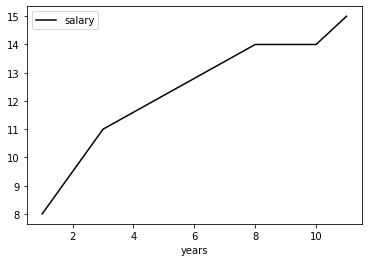

In [3]:
years = [1, 3, 8, 10, 11]
salary = [8, 11, 14, 14, 15]
values = list(zip(years, salary))
names = ['years', 'salary']
df = pd.DataFrame(values, columns=names)
df.plot.line('years', 'salary', color='black')
plt.show()

This relationship is still called **monotonic (increasing)**, despite the fact that the *salary* is the same for *years* = 8 **and** *years* = 10. The relationship is just not called **strictly monotonic** anymore.

Let's consider you collected even more data and this is the resulting relationship:

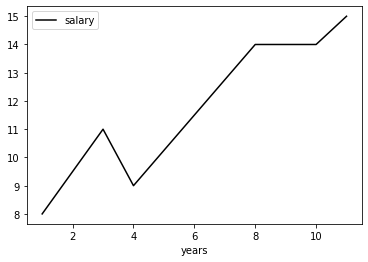

In [4]:
years = [1, 3, 4, 8, 10, 11]
salary = [8, 11, 9, 14, 14, 15]
values = list(zip(years, salary))
names = ['years', 'salary']
df = pd.DataFrame(values, columns=names)
df.plot.line('years', 'salary', color='black')
plt.show()

The result is a **non-monotonic** function, since the *salary* at *years* = 4 is lower than the *salary* at *years* = 3, *and* lower than the *salary* at *years* = 8. 

* in reality, most relationships between your feature and the target will *not* be monotonic
* we most likely will *not* achieve *perfectly* monotonic relationships using feature engineering 
* we should still model *as monotonic relationships as possible*
* **metrics for monotony** can be used to compare the monotony of the original feature and our engineered features.
* my naive metric for monotony counts all **monotony-violations** as seen in the last plot and it is calculated as $montony = 1 - \frac{|\text{monotony violations}|}{|\text{samples}|}$


In [5]:
import numpy as np
from operator import lt, gt

def count_monotony_violations(feat_targ: np.ndarray, comparison) -> int:
    vio = 0
    for i in np.arange(start=1, stop=len(feat_targ)):
        if comparison(feat_targ[i-1, 1], feat_targ[i, 1]):
            vio += 1
    return vio

def naive_monotony_score(feature: pd.Series, target: pd.Series) -> dict:
    """
    A naive score for determing the "amount of monotony" 
    in the relationship between a feature and the target
    """
    
    # sort with first priority: feature, second priority: target
    feat_targ = pd.concat([feature, target], axis=1)
    feat_targ_sorted = df.sort_values([feature.name, target.name], ascending=[True, True]).values
    
    n = len(feat_targ_sorted)
    inc_violations = count_monotony_violations(feat_targ=feat_targ_sorted, comparison=gt)
    inc_score = 1 - inc_violations / n
    
    dec_violations = count_monotony_violations(feat_targ=feat_targ_sorted, comparison=lt)
    dec_score = 1 - dec_violations / n

    return {"dec_violations": dec_violations, "dec_score": dec_score, "inc_violations": inc_violations, "inc_score": inc_score}

In [6]:
print(naive_monotony_score(feature=df["years"], target=df["salary"]))

{'dec_violations': 3, 'dec_score': 0.5, 'inc_violations': 1, 'inc_score': 0.8333333333333334}


As we can see, the relation is an almost **monotonically increasing function**. However, this approach is pretty naive, since it makes too many assumptions about the data. These are some of the reasons, why simply checking for monotony this way might be **problematically**:

* Feature values might be **non-unique** which rises multiple opportunities (E.g. should we use the mean/median target value in these cases?)
* Functions might have many local minima and maxima, but they could still follow a monotonic trend when smoothed.

We can use a conceptionally pretty similar indicator for approximate (linear) monotony, the so-called **Pearson Correlation Coefficient**.

<a id="sec12"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 1.2. Pearson Correlation and Collinearity</h1>


The Pearson Correlation Coefficient indicates the degree to which two variables have a linear relationship. A perfect linear relationship is by definition a [monotonic relationship](#sec11).


Our goal is to reach:

* as **strong correlations between every single feature and the target** as possible

* as **weak correlations between multiple features** (**(multi) collinearity**) as possible.

* (Pearson) correlation coefficient attains values between -1 and 1. 

* high *negative* correlation indicates a linear relationship with *negative* slope

* high *positive* correlation indicates a linear relationship with a *positive* slope

* the absolute value of the Pearson correlation coefficient tells us the "amount of linearity"

* **low absolute correlation:** 0.3 to 0.5
* **moderate absolute correlation:** 0.5 to 0.7
* **high absolute correlation:** 0.7 to 0.9
* **very high absolute correlation:** 0.9 to 0.1


Take a look at the [this visualization](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#/media/File:Correlation_examples2.svg) of different pearson correlation values to get some feeling for the way positive and negative correlation works.



Let's take a look at an example for visualizing the (absolute) correlation coefficients of three variables, the *years* which an employee used to work in your company, his *motivation*, and his *salary*. The salary is the target variable. 

In [7]:
years = [1, 3, 4, 8, 10, 11]
motivation = [0.1, 0.4, 0.6, 0.4, 0.9, 1]
salary = [8, 11, 9, 14, 14, 15]
values = list(zip(years, motivation, salary))
names = ['years', 'motivation', 'salary']
df = pd.DataFrame(values, columns=names)
df

,years,motivation,salary
0,1,0.1,8
1,3,0.4,11
2,4,0.6,9
3,8,0.4,14
4,10,0.9,14
5,11,1.0,15


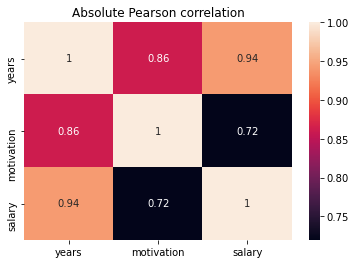

In [8]:
import seaborn as sns

ax = plt.axes()
ax.set_title('Absolute Pearson correlation')
sns.heatmap(np.abs(df.corr()), annot=True)
plt.savefig('correlation')
plt.show()

As we can see, both features (*years, motivation*) are highly correlated to the target (*salary*). Unfortunately, the features are highly correlated to each other as well. We could either try to merge these two features e.g. by using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), or discard one feature from the dataset in order to **evade multicollinearity**.

In this example we drop the multicollinear feature, which is less correlated to the target: 

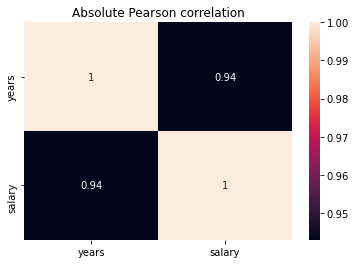

In [9]:
df = df.drop('motivation', axis=1)
ax = plt.axes()
ax.set_title('Absolute Pearson correlation')
sns.heatmap(np.abs(df.corr()), annot=True);

We end up having no multicollinearity, which might improve the performance of our machine learning model.

<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to Topics</a>

<a id="sec2"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 2. Univariate Transformations on Numerical Data </h1>


Numerical features may...
* follow a [long-tailed distribution](#tail) which dominates the underlying calculations in models
* have a complex relationship with the target that can be simplified
* be represented inefficiently, sometimes simply **normally distributed representations may already improve the performance**

### One often wants data to be **normally distributed**, but why?
* the distribution conven is defined by the mean and the variance
* the normal distribution is [symmetric](#tail), which has some significant impact on the performance of many models 
* based on the [central limit theorem](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/BS704_Probability12.html), many machine learning models [assume the feature values to be drawn from a normally distributed population](https://stackoverflow.com/questions/54071893/a-feature-distribution-is-nearly-normal-what-does-that-imply-for-my-ml-model)

<a id="sec21"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 2.1. Scaling, Centering, and Standardization </h1>

When talking about this topic, people tend to mix the following terms:
* [Centering](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) refers to subtracting the mean of a feature
* [Standardization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) refers to subtracting the mean of a feature and dividing it by its standard deviation
* [Range Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) refers to using the Minimum and the Maximum value of a feature to rescale the data on a different scale (e.g. between 0 and 1)

<a id="sec211"></a>
## Centering and Standardization
The transformed numerical feature will...
* have a *mean* of $0$
* have a standard deviation of $1$ 

Let's take a look at some data containing the age of some *pets* and whether they are *house trained* or not:

In [10]:
age = [3, 4, 2, 7, 8, 104,5]
house_trained = [1, 1, 0, 1, 0, 0, 1]
values = list(zip(age, house_trained))
names = ['age', 'house_trained']
df = pd.DataFrame(values, columns=names)
df

,age,house_trained
0,3,1
1,4,1
2,2,0
3,7,1
4,8,0
5,104,0
6,5,1


In [11]:
from sklearn.preprocessing import StandardScaler

# centering = subtract the mean
center = StandardScaler(with_std=False)
df['centered'] = center.fit_transform(df['age'].values.reshape((-1,1)))

# standardization = divide a centered feature by its' std
std = StandardScaler()
df['standardized'] = std.fit_transform(df['age'].values.reshape((-1,1)))
df

,age,house_trained,centered,standardized
0,3,1,-16.0,-0.460348
1,4,1,-15.0,-0.431577
2,2,0,-17.0,-0.489120
3,7,1,-12.0,-0.345261
4,8,0,-11.0,-0.316489
5,104,0,85.0,2.445600
6,5,1,-14.0,-0.402805


<a id="sec212"></a>
## Range Scaling
The transformed numerical feature will...
* have a similarly formed distribution as the original feature
* still contain outliers
* contain values between $0$ and $1$ by default, which enables further transformations like the [Logit Transformation](#sec24)
* be especially beneficial for models, which assume the data to be on the same scale (distance-based methods like KNN), if applied to all numerical features

In [12]:
from sklearn.preprocessing import MinMaxScaler

# self defined interval after transformation: [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1)) 
df['minmax']  = scaler.fit_transform(df['age'].values.reshape((-1,1)))
df

,age,house_trained,centered,standardized,minmax
0,3,1,-16.0,-0.460348,-0.980392
1,4,1,-15.0,-0.431577,-0.960784
2,2,0,-17.0,-0.489120,-1.000000
3,7,1,-12.0,-0.345261,-0.901961
4,8,0,-11.0,-0.316489,-0.882353
5,104,0,85.0,2.445600,1.000000
6,5,1,-14.0,-0.402805,-0.941176


<a id="sec213"></a>
## Robust Scaling

$\Large
     x_{transformed}=\frac{x - median(x)}{q_{75}(x) - q_{25}(x)} \text{ ,with } q_{n} \text{ being the n-th quantile}
$

This transformation...
* centers the feature using the **median** instead of the mean
* **median centering** doesn't shift the feature as much into the negative direction of the outlier than **(mean) centering** (i.e. median centering is more robust to outliers)
* **outliers will (most likely) stay outliers**
* **doesn't ensure the features to be on the same scale**, because it is performed on every feature individually (so maybe a bad choice for distance based algorithms)

In [13]:
from sklearn.preprocessing import RobustScaler

# median centering by subtracting the median instead of the mean
df['median_centered'] = df['age'] - np.median(df['age'].values.reshape((-1,1)))

df['robust'] = RobustScaler().fit_transform(df['age'].values.reshape((-1,1)))
df

,age,house_trained,centered,standardized,minmax,median_centered,robust
0,3,1,-16.0,-0.460348,-0.980392,-2.0,-0.50
1,4,1,-15.0,-0.431577,-0.960784,-1.0,-0.25
2,2,0,-17.0,-0.489120,-1.000000,-3.0,-0.75
3,7,1,-12.0,-0.345261,-0.901961,2.0,0.50
4,8,0,-11.0,-0.316489,-0.882353,3.0,0.75
5,104,0,85.0,2.445600,1.000000,99.0,24.75
6,5,1,-14.0,-0.402805,-0.941176,0.0,0.00


<a id="sec22"></a>
<a id="log"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 2.2. Log Transformation </h1>

$\Large
     x_{transformed}=ln(x)
$
* suitable for data which approximately follows a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)
* is a special case of the [Box-Cox Power Transformation](#box-cox)

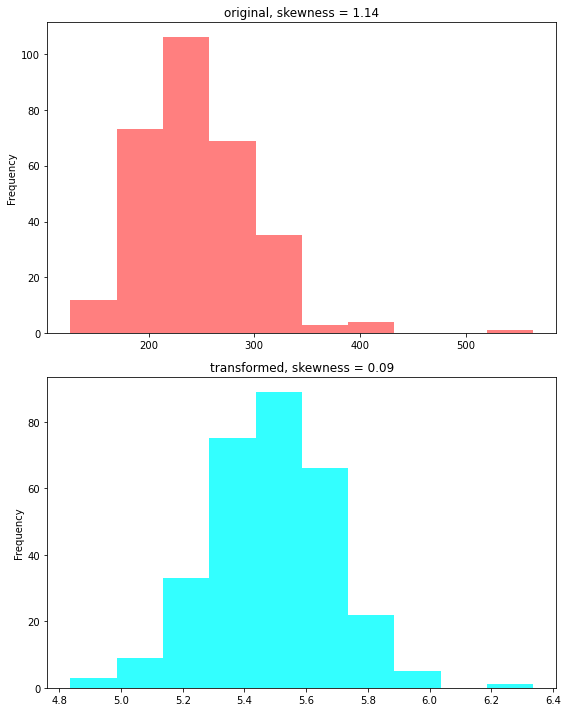

In [14]:
from scipy import stats

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

skewness = stats.skew(chol)
title = f'original, skewness = {round(skewness, 2)}'
chol.plot(kind='hist', ax=ax1, color='red', alpha=0.5, title=title)
chol_t = chol.apply(np.log)
chol_t = pd.Series(chol_t)
skewness_t = stats.skew(chol_t)
title_t = f'transformed, skewness = {round(skewness_t, 2)}'
chol_t.plot(kind='hist', ax=ax2, color='cyan', alpha=0.8, title=title_t)

plt.tight_layout()
plt.show()

<a id="sec23"></a>
<a id="box-cox"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 2.3. Box-Cox Power Transformation </h1>

$\Large
     x_{transformed}=\left\{\begin{array}{ll} \frac{x^\lambda -1}{\lambda}, & \lambda\neq 0 \\
         ln(x), & \lambda = 0\end{array}\right. 
$
  
  
  
* transforms the feature into normal shape
* the parameter $\lambda$ might be set explicitly or might be estimated to obtain **as normally distributed data as possible**
* different $\lambda$ cover the Identity Transformation, the [Log Transformation](#log), the Square Root Transformation, the Inverse Transformation, and no-name transformations in between
* requires the data to be positive
* is a [variance stabilizing transformation](https://en.wikipedia.org/wiki/Variance-stabilizing_transformation) 
* the [scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) allows us to store the best lambda. We can apply a Box-Cox transformation with that lambda value when predicting outcomes for our test data/ validation data

Another Power Transformation that might be interesting is the [Yeo Johnson transformation](https://www.stat.umn.edu/arc/yjpower.pdf). It allows the feature to contain negative values

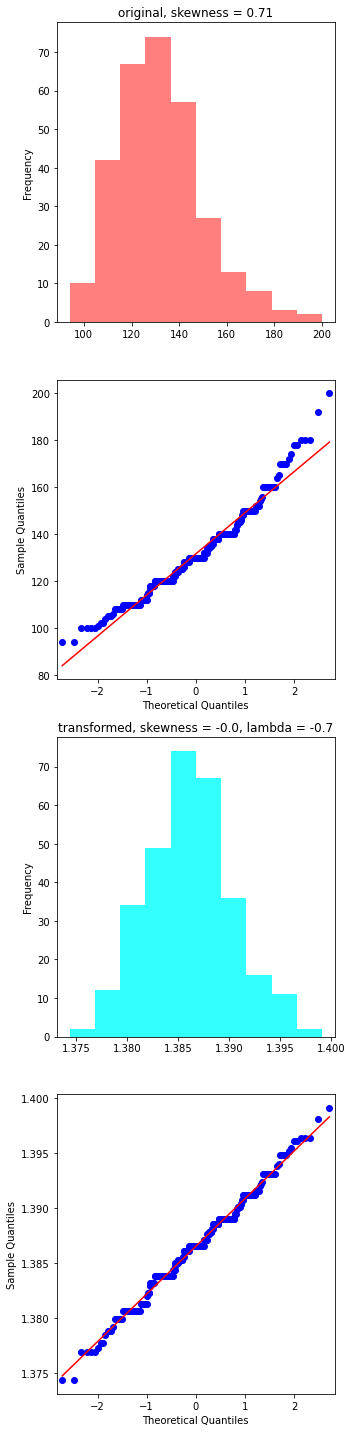

In [15]:
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(5, 20))

# original
skewness = stats.skew(trestbps)
title = f'original, skewness = {round(skewness, 2)}'
trestbps.plot(kind='hist', ax=ax1, color='red', alpha=0.5, title=title)

##qqplot
qqplot(data=trestbps, dist="norm", ax=ax2, line='s')

# transformation
trestbps_t, lmbda_best = stats.boxcox(trestbps)
trestbps_t = pd.Series(trestbps_t)
skewness_t = stats.skew(trestbps_t)
title_t = f'transformed, skewness = {round(skewness_t, 2)}, lambda = {round(lmbda_best, 2)}'
trestbps_t.plot(kind='hist', ax=ax3, color='cyan', alpha=0.8, title=title_t)

##qqplot
qqplot(data=trestbps_t, dist="norm", ax=ax4, line='s')


plt.tight_layout()
plt.savefig('.png')
plt.show()

As we can see in the [qqplots](qqplot), the data used to be [right skewed](#tail) and matches the normal distribution way better now.

https://en.wikipedia.org/wiki/Power_transform

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

https://www.statisticshowto.com/box-cox-transformation/

https://en.wikipedia.org/wiki/Variance-stabilizing_transformation

https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.special.logit.html

http://strata.uga.edu/8370/rtips/proportions.html

https://www.statsdirect.com/help/data_preparation/transform_logit.htm

<a id="sec24"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 2.4. Binning with Decision Trees </h1>

Binning transforms numerical features into categorical features. There are several approaches like taking Quantiles as bin limits, or any arbitrary numbers. For example if your job is to find out whether patients which are older than 60 have a higher chance to have a specific illness, it might be interesting to bin the numerical age feature using the intervals $(0, 60)$ and $[60,\text{inf})$. One of the less self-explaining methods of binning is **Binning with Decision Trees:**
* The bins will not necessarily contain equal numbers of cases but it instead checks for patterns in the data
* Each predicted probability will form one category
* Since Predictions are made in the leaf nodes, and multiple leaves could make the same predictions, we end up having as many categories as leaf nodes or fewer
* Usually improves the **correlation with the target**, due to having a [monotonical relation with the target](https://www.statisticshowto.com/monotonic-relationship/)
* handles outliers, since they are assigned to one of the bins

In [16]:
df_heart_failure = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
c_p = df_heart_failure['creatinine_phosphokinase']
target_heart_failure = df_heart_failure['DEATH_EVENT']

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
x = c_p.values.reshape(-1,1)

hyperparameter = {'max_depth' : [1,2,4, 6, 8]}
val = GridSearchCV(DecisionTreeClassifier(), 
                         hyperparameter, cv=5, 
                         scoring='roc_auc')

val.fit(x, target_heart_failure)
disc_tree = val.best_estimator_
# do this on bith, train and test set:
x_binned = pd.Series(disc_tree.predict_proba(x)[:,1], name='x_binned')

Let's take a look at the Resulting categories, the tree, and the correlation improvement.

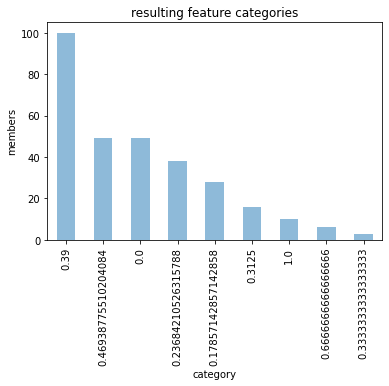

In [17]:
x_binned.value_counts().plot.bar(title='resulting feature categories', alpha=0.5, xlabel="category", ylabel="members")
plt.show()

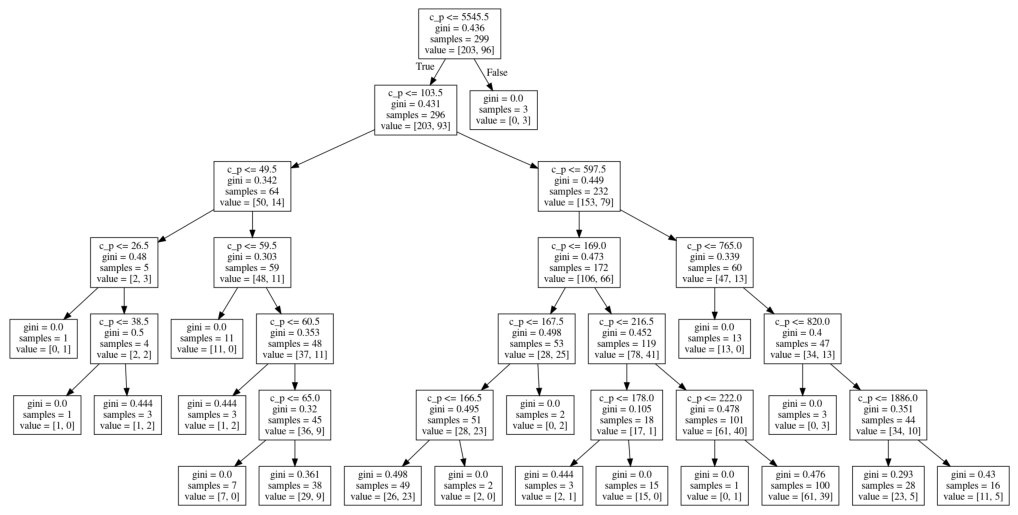

In [18]:
from sklearn.tree import export_graphviz
import cv2

export_graphviz(disc_tree, 'tree.dot', feature_names = ['c_p'])
! dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (18, 18))
plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
cor = np.corrcoef(target_heart_failure, x.flatten())[0][1]
cor_transformed = np.corrcoef(target_heart_failure, x_binned)[0][1]
print(f'The Pearson Correaltion between the Target and the numerical feature: {round(cor, 2)}')
print(f'The Pearson Correaltion between the Target and the binned feature: {round(cor_transformed, 2)}')

The Pearson Correaltion between the Target and the numerical feature: 0.06
The Pearson Correaltion between the Target and the binned feature: 0.44


Note: I didn't finetune any hyperparameters but in practice you should always do that.


further sources: 

https://www.youtube.com/watch?v=vsKNxbP8R_8?t=1388

https://towardsdatascience.com/discretisation-using-decision-trees-21910483fa4b



<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to Topics</a>

<a id="sec3"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 3. Encode Categorical Data </h1>

Categorical features contain discrete values or even strings. The number of unique values a categorical feature contains is called **cardinality**. 

We might have to use encoding methods to transform the categorical features into a suitable representation.

<a id="sec31"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 3.1. Label Encoding </h1>

Label Encoders are probably the most simple way to encode a categorical feature. The Resulting Encoding has the following properties:
* encodes the feature into one column (so we don't struggle with having too many features)
* consecutive integers, starting at 0. 
* problem: indicates **non-meaningful** numerical *hierarchies* and *distances* between the categories ($ 1 < 2$ and $1 = 0.5 \cdot 2$)
* some models like *Linear Regression* might assign more meaning to categories with very high or very low identifiers, because they assume *hierarchies* and *distances* to be encoded in the feature
* in most cases, it  **violates** the **key idea** of forcing features to have a monotonic relationship with the target.


Let's apply our encodings to some data about *pets*, the *houses* in which they live and whether they are *house trained* or not.

In [20]:
house_nr = [1, 3, 3, 2, 1, 1, 3, 2, 2, 2, 1, 1]
pet = ['dog', 'cat', 'dog', 'dog', 'rabbit', 'mouse', 'cat', 'rabbit', 'dog', 'cat', 'rat', 'rat']
house_trained = [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]
values = list(zip(house_nr, pet, house_trained))
names = ['house_nr', 'pet', 'house_trained']
df = pd.DataFrame(values, columns=names)
df

,house_nr,pet,house_trained
0,1,dog,1
1,3,cat,1
2,3,dog,0
3,2,dog,1
4,1,rabbit,0
5,1,mouse,1
6,3,cat,1
7,2,rabbit,1
8,2,dog,1
9,2,cat,0


In [21]:
# import a label encoder from sklearn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_label = df.copy()

# fit -> create parameters for the encoding (which category will be encoded as which integer?)
# transform -> encode the feature using the parameters
# fit_transform -> performs both, fit and transform
# fit_transform on training data, transform on test data
df_label['pet'] = le.fit_transform(df_label['pet'])
df_label['house_nr'] = le.fit_transform(df_label['house_nr'])
df_label

,house_nr,pet,house_trained
0,0,1,1
1,2,0,1
2,2,1,0
3,1,1,1
4,0,3,0
5,0,2,1
6,2,0,1
7,1,3,1
8,1,1,1
9,1,0,0


As we can see, each *pet* has a new integer representation. Note that *house_nr* contains now values from a consecutive sequence of integers starting at 0.

Let's focus on the feature *pet* and the target *house_trained*. The relationship between these features is not monotonic, as we can see in the following plot:

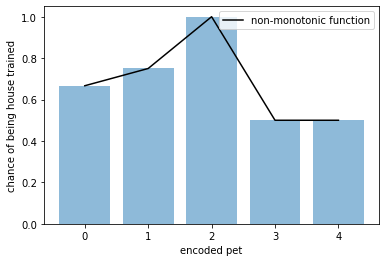

In [22]:
grouped_by_pet = df_label.groupby('pet')['house_trained'].mean()

plt.bar(x=grouped_by_pet.index, height=grouped_by_pet.values, alpha=0.5)
grouped_by_pet.plot.line(color='black', label='non-monotonic function')
plt.xlabel('encoded pet')
plt.ylabel('chance of being house trained')
plt.legend()
plt.show()

As we can see, higher feature values don't necessarily relate to higher chances of having a higher target value, so we don't have a *monotonic relationship* with the target. 
We could simply define a custom Label Encoding, which enforces our encoding to choose *higher values* for categories, which lead to a *higher chance* of belonging to the *positive class*. 
You should consider using such an encoding method if you want to keep the number of features low.

<a id="sec32"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 3.2. One-Hot Encoder </h1>

The encoded feature will have the following properties:
* Each *category* is stored in a separate, new column.
* Each of these new columns contains solely zeroes and ones.
* ones indicate, that the observation is of the respective category.
* Each of these new columns has a *monotonic relationship with the target*.

Nevertheless, there are still some downsides of using this method:
* Huge drawback: multiple new columns, which might lead to a worse model due to the [Curse of Dimensionaility](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
* In many cases, it makes sense to merge very uncommon categories into one category called *' other'* in order to evade having many columns containing very few ones. For example, you could merge all categories together, which occur in less than 5% of your *observations*.

In [23]:
# import a one-hot encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

# we will focus on the feature 'pet'
df_oh = df.copy().drop(['house_nr'], axis=1)

# creates the new features
dummies = pd.get_dummies(df_oh['pet'])

# adds the new features to our dataframe
df_oh = pd.concat([df_oh, dummies], axis=1)
df_oh

,pet,house_trained,cat,dog,mouse,rabbit,rat
0,dog,1,0,1,0,0,0
1,cat,1,1,0,0,0,0
2,dog,0,0,1,0,0,0
3,dog,1,0,1,0,0,0
4,rabbit,0,0,0,0,1,0
5,mouse,1,0,0,1,0,0
6,cat,1,1,0,0,0,0
7,rabbit,1,0,0,0,1,0
8,dog,1,0,1,0,0,0
9,cat,0,1,0,0,0,0


As you can see, each row contains just a single $1$ within the new columns, since each case still belongs solely to one of the categories. 

Moreover, the common machine learning models can handle this representation of the feature very well, since a category will be either recognized to be absent or not. Last but not least, every new column has either a positive or a negative *monotonic and linear* relationship with the target (for obvious reasons, since there are only two discrete values per column).

Let's for example take a look at the relationship between the column *rabbit* and the target:

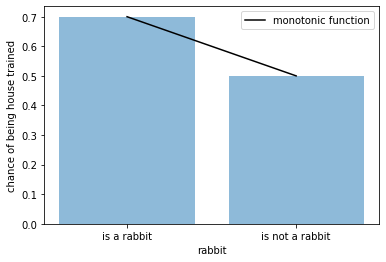

In [24]:
grouped_by_rabbit = df_oh.groupby('rabbit')['house_trained'].mean()

#fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(11,7))
plt.bar(x=grouped_by_rabbit.index, height=grouped_by_rabbit.values, alpha=0.5)
grouped_by_rabbit.plot.line(color='black', label='monotonic function')
plt.ylabel('chance of being house trained')
plt.xticks([0, 1], ['is a rabbit', 'is not a rabbit'])
plt.legend()
plt.show()

As you can see, being a rabbit provides a higher chance of being house trained than not being a rabbit. This relationship is easily interpreted by the model. In a regression task, binary columns like this could indicate either higher or lower target values.

<a id="sec33"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 3.3. Target-Mean Encoding </h1>

$\Large
     x_{transformed}=\frac{|y=1_{X=x}|}{|X=x|} 
$

This encoding method for classification problems with **binary targets** (i.e. two classes) is an elaborate alternative to the commonly used ones.

* **Encoding:**  $
    \frac{\text{observations of the  positive class with the respective feature value}}{\text{observations with the respective feature value}}
$
* Provides a monotonic relationship between the feature and the target
* Encodes the feature within **one column** and thus doesn't lead to huge amounts of new columns in contrast to [One-Hot Encoding](#sec31)
* Might decrease the [cardinality](#sec3) of the categorical feature (e.g. 2 values might be encoded as 0.5 and thus would merge into one category)
* **Alternative for non-binary classification tasks:** create one Target-Mean encoded column for each target value and treat the respective target value as positive, and all other target values as negative

Assume we have a dataset containing several pets from your friends and whether they are house trained or not. We want to Target-Mean Encode the categorical feature *pet* with respect to the target *house_trained*.

In [25]:
pet = ['dog', 'cat', 'dog', 'dog', 'rabbit', 'mouse', 'cat', 'rabbit', 'dog', 'cat', 'rat', 'rat']
house_trained = [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]
values = list(zip(pet, house_trained))
names = ['pet', 'house_trained']
df = pd.DataFrame(values, columns=names)
df

,pet,house_trained
0,dog,1
1,cat,1
2,dog,0
3,dog,1
4,rabbit,0
5,mouse,1
6,cat,1
7,rabbit,1
8,dog,1
9,cat,0


In [26]:
def target_mean_encode(feature, target):
    encoded = feature
    for val in feature.unique():
        ser_pure = feature[feature==val]
        target_pure = target[ser_pure.index].sum()
        encoded = encoded.replace(val, target_pure/len(ser_pure))
    return encoded


pet_encoded = target_mean_encode(feature=df['pet'], target=df['house_trained'])
df_with_encoding = pd.concat([df, pet_encoded.rename('pet_encoded')], axis=1)
df_with_encoding

,pet,house_trained,pet_encoded
0,dog,1,0.750000
1,cat,1,0.666667
2,dog,0,0.750000
3,dog,1,0.750000
4,rabbit,0,0.500000
5,mouse,1,1.000000
6,cat,1,0.666667
7,rabbit,1,0.500000
8,dog,1,0.750000
9,cat,0,0.666667


As we can see, rats and rabbits end up having the same encoding. Thus, the encoding has a *cardinality* of 4, whereas the original feature had a *cardinality* of 5.

<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to Topics</a>

<a id="sec-2"></a>
***

<h1 style="background-color:DodgerBlue; color:white" >-> 4. Combine Features </h1>

Many machine learning algorithms utilize feature interactions and combinations implicitly. However, experience has shown that it still might be a good idea to combine features manually, because we can't rely on our model 'doing all the work'.


Finding and combining features could be important for standing out in Kaggle competitions, but finding useful combinations might be a non-trivial problem. Suggestions from **domain experts** are oftentimes the best entry point to detecting valuable combinations.

Besides relying on domain experts, we could try many possible combination of features to identify model improving ones. This approach takes much time, but at least we can already find many of the most important combinations if we follow these guidelines: 
* **effect sparsity:** the fewer features are part of the combination, the higher the chance for the combination to be predictive (including singletons, i.e. uncombined features). We should focus on combinations between 2 or 3 features.
* **(weak) heredity:** the combination $(feat_1, feat_2)$ should only be considered to be predictive, if at least one of the features, $feat_1$ or $feat_2$, is already known to be predictive.
* **priority:** in most cases, the interpretability and the predictivity of a combination is better when the original features aren't transformed ([scaled](#sec21), encoded, [log-transformed](#log)...). Thus we should create the combinations *prior* to any transformations.

As suggested by [@anashamoutni](https://www.kaggle.com/anashamoutni), [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and other [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) methods can be seen as methods for combining features as well, since they merge multiple features in a more or less meaningful way.

Some examples for basic building blocks:

* Products of numerical features (E.g. daily cigarettes ⋅ days)
* Ratios of numerical features (E.g. $\frac{price}{gram}$)
* Sums of numerical features (E.g. weight of passengers + weight of the transported goods)
* Differences of numerical values (E.g. workdays - sick days)

The whole equation for a new feature parent
that describes the likelihood of an employee going on parental leave (*parent*), given the numerical features *age*, and the years of employment (*empl*), as well as the binary categorical features *sex* (female), and the marital status (*married*) could look like this:

$\large
     \text{parent} =(1+0.7married)\frac{empl}{age^5} 
$

Take a moment to think about the way the binary categorical features affect this equation.

Let's apply this equation to some data to see if it works:

In [27]:
married = [0, 1, 1, 1, 0, 1, 0]
empl = [2, 5, 1, 6, 2, 6, 1]
age = [25, 27, 43, 43, 28, 29, 22]
female = [0, 1,  0, 0, 1, 0, 1]
values = list(zip(married, empl, age, female))
names = ['married', 'empl', 'age', 'female']
df = pd.DataFrame(values, columns=names)
df

,married,empl,age,female
0,0,2,25,0
1,1,5,27,1
2,1,1,43,0
3,1,6,43,0
4,0,2,28,1
5,1,6,29,0
6,0,1,22,1


In [28]:
c = 10_000_000 # a constant for better readability

def parent(row):
    return  c*(1 + 0.7*row['married'])*row['empl']/(row['age']**5)
    

    
parent = df.apply(parent, axis=1) # axis=1 for row-wise operation
df_with_parent = pd.concat([df, parent.rename('parent')], axis=1)
df_with_parent

,married,empl,age,female,parent
0,0,2,25,0,2.048000
1,1,5,27,1,5.923796
2,1,1,43,0,0.115640
3,1,6,43,0,0.693838
4,0,2,28,1,1.162090
5,1,6,29,0,4.972905
6,0,1,22,1,1.940379


As we can see, young people who are employed for several years are very likely to go on parental leave. Moreover, the likelihood increases a lot if the employee is female and even more if the employee is married. Note, that this approach benefits from some implicit constraints. Since we are taking a look at employee data, there will be no Kid in this dataset. According to this equation, kids would be extremely likely to become parents within the next year.

<a id="sec-22"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 4.2. Combine Features using Groupby</h1>

Imagine having data about your employees' salary and their department. The salary on its own might already be an important feature, but it might be helpful to have the clerks relative salary per department.

In [29]:
salary = [40, 42, 30, 32, 45, 44, 31, 44, 29, 33, 46, 50, 33, 39]
dep =[1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 1, 2, 0]
values = list(zip(salary, dep))
names = ['salary', 'dep']
df = pd.DataFrame(values, columns=names)
df

,salary,dep
0,40,1
1,42,1
2,30,0
3,32,0
4,45,2
5,44,2
6,31,1
7,44,0
8,29,1
9,33,0


In [30]:
sum_per_dep = df.groupby('dep')['salary'].sum()

sum_per_dep_rows = df['dep'].replace(sum_per_dep.index, sum_per_dep.values)
salary_per_dep = df['salary'] / sum_per_dep_rows
dep_relative_salary = pd.concat([df, salary_per_dep.rename('dep_relative_salary')], axis=1)
dep_relative_salary

,salary,dep,dep_relative_salary
0,40,1,0.208333
1,42,1,0.218750
2,30,0,0.168539
3,32,0,0.179775
4,45,2,0.267857
5,44,2,0.261905
6,31,1,0.161458
7,44,0,0.247191
8,29,1,0.151042
9,33,0,0.185393


<a id="sec-23"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 4.3. Combine Features using Conditions</h1>

One more very common method of creating a new feature by combining the original features is using conditions. This method is especially important if your project demands you to focus on a particular group of observations, or when you already figured out any frequent sets in your Dataset.

* Use this method for commonly fulfilled conditions 
* The conditions should contain multiple features, to evade *collinearity*
* Construct the condition based on your project goals or frequent patterns in your data
* You can find frequent patterns in your data using the [Apriori Algorithm](https://www.youtube.com/watch?v=guVvtZ7ZClw)

Imagine your data exploration reveals the fact that a particular combination of features occurs frequently with a particular outcome. In such a case, it might be interesting to create a *binary flag*, indicating the particular combination. Of course, the algorithm could find this relationship out automatically, but we can never be sure about it. 

For example, we could have found out, that all young customers, who already bought multiple products from our company are very interested in our new product. Let's call these young people *young fans*. Creating such a feature could look like this:

In [31]:
age = [23, 24, 51, 41, 24, 72, 35, 21, 64, 29, 27]
products_bought =[1, 4, 3, 2, 3, 1, 5, 1, 2, 7, 4]
values = list(zip(age, products_bought))
names = ['age', 'products_bought']
df = pd.DataFrame(values, columns=names)
df

,age,products_bought
0,23,1
1,24,4
2,51,3
3,41,2
4,24,3
5,72,1
6,35,5
7,21,1
8,64,2
9,29,7


In [32]:
def is_young_fan(df) : 
    if df['age'] < 30 and (df['products_bought'] > 1):
        return 1
    else : 
        return 0
    
df['young_fan'] = df.apply(is_young_fan, axis=1)
df

,age,products_bought,young_fan
0,23,1,0
1,24,4,1
2,51,3,0
3,41,2,0
4,24,3,1
5,72,1,0
6,35,5,0
7,21,1,0
8,64,2,0
9,29,7,1


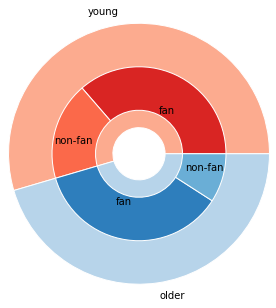

In [33]:
def is_young(age):
    return int(age < 30)

young = df['age'].apply(is_young)
young_count = young.sum()
older_count = len(young) - young_count



def is_fan(products_bought):
    return int(products_bought > 1)

fan = df['products_bought'].apply(is_fan)
young_fan_count = df['young_fan'].sum()
young_non_fan_count = young_count - young_fan_count
older_fan_count = fan.sum() - young_fan_count
older_non_fan_count = older_count - older_fan_count



# colors by colormap
color_f, color_m = [plt.cm.Reds, plt.cm.Blues]

# outer
outer_names = ['young', 'older'] # female male
outer_size = [young_count, older_count]
fig, ax = plt.subplots()
pie_outer, _ = ax.pie(outer_size, radius=1.5, labels=outer_names, colors=[color_f(0.3), color_m(0.3)] )
plt.setp( pie_outer, width=1.2, edgecolor='white')
 
# inner
inner_names = ['fan', 'non-fan', 'fan', 'non-fan']
inner_size = [young_fan_count, young_non_fan_count, older_fan_count, older_non_fan_count]
pie_inner, _ = ax.pie(inner_size, radius=1, labels=inner_names, labeldistance=0.55, colors=[color_f(0.7), color_f(0.5), color_m(0.7), color_m(0.5)])
plt.setp(pie_inner, width=0.5, edgecolor='white')
plt.margins(0,0)
plt.savefig('fan.png')
plt.show()

<a id="sec-5"></a>
***

<h1 style="background-color:DodgerBlue; color:white" >-> 5. Distributions </h1>


<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to Topics</a>

<a id="sec51"></a>
<a id="tail"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 5.1. Distribution Tails</h1>

* **tail:** The part on the left side of the modes of the distribution is called the left tail and vice versa.
* **heavy-tailed distribution:** A Distribution with a bigger area under the curve in the tails than a normal distribution
* **long-tailed distribution:** A distribution with a long tail has some values which are far away from the mean of the distribution on the respective side of the mean(most long tails are also **"thin"** for obvious reasons). long-tailed distributions contain many outliers; vice versa:**short and fat** 
* **skewness:** describes the asymmetry of a distribution
* **negative skew:** distribution tends to have a long tail on the left side
* **positive skew:** distribution tends to have a long tail on the right side
* **zero skewness:** both sides of the modes balance out overall. (e.g. symmetry or one tail is long and thin and the other is short but fat
* [**kurtosis:**](https://corporatefinanceinstitute.com/resources/knowledge/other/kurtosis/) measures the conformity of the tails of a distribution with the tails of a normal distribution

<a id="sec52"></a>
<a id="qqplot"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 5.2. The Quantile-Quantile Plot (qqplot)</h1>

* plots the [quantiles](https://en.wikipedia.org/wiki/Quantile) (basically just the data sorted in ascending order) of two variables against each other
* each axis represents one of these variables
* the more similar the distributions of the variables are, the more looks the plot like the line formed by $x=y$
* quantile plots underneath the line have lower $y$-variable values than $x$-variable values and vice versa
* is oftentimes used to determine graphically, whether the data follows any known distribution like the normal distribution (by plotting these known distributions against the data)
* take a look at these [typical qqplot results](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot) and the respective interpretations regarding [skewness and kurtosis](#tail).

<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to Topics</a>

<a id="sec6"></a>
***
<h1 style="background-color:DodgerBlue; color:white" >-> 6. Further Readings & Helpful Videos</h1>

I hope that you noticed, that I tried to add some resources for further readings. Maybe I already linked you to some of them, but I want to emphasize the importance of these sources for this notebook:

https://www.youtube.com/watch?v=lUg0dRrlsoA

https://www.youtube.com/watch?v=vsKNxbP8R_8

https://www.youtube.com/watch?v=X4pWmkxEikM

https://www.goodreads.com/book/show/45832399-feature-engineering-and-selection


<div class="alert alert-danger" role="alert">
    <h3>Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>

<a href="#top" class="btn btn-info btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to Topics</a>